# Generate h5ad input file

In [69]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# from starmap.obj import STARMapDataset, load_data
# import starmap.analyze as anz
# import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# test
from starmap.utilities import *
from starmap.sequencing import *
from anndata import AnnData

# test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

## IO

In [71]:
# Set path
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')

out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

In [72]:
# Load data

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

In [73]:
adata

AnnData object with n_obs × n_vars = 76847 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau'

## Modify annotation

In [74]:
adata.obs['temp'] = adata.obs['sample'].values
adata.obs[['temp', 'sample']] = adata.obs['temp'].str.split('-', 1, expand=True)
adata.obs[['temp', 'group']] = adata.obs['temp'].str.split('_', 1, expand=True)
adata.obs['time'] = adata.obs['temp'].values
adata.obs = adata.obs.drop(columns=['temp'])

In [75]:
# change obs columns to categorical variable 
sample_list = ['ADmouse_9723', 'ADmouse_9735', 'ADmouse_9494', 'ADmouse_9498', 'ADmouse_9723_2', 'ADmouse_9707', 'ADmouse_11346', 'ADmouse_11351']
batch_list = ['batch_1', 'batch_1', 'batch_2', 'batch_2', 'batch_3', 'batch_4', 'batch_4', 'batch_4']
batch_dict = dict(zip(sample_list, batch_list))

adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(sample_list)

adata.obs['batch'] = adata.obs['sample'].values
adata.obs['batch'] = adata.obs['batch'].map(batch_dict)
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2', 'batch_3', 'batch_4'])

adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8months', '13months'])

adata.obs['group'] = adata.obs['group'].astype('category')
adata.obs['group'] = adata.obs['group'].cat.reorder_categories(['disease', 'control'])

## Quality assessment

### Statistics

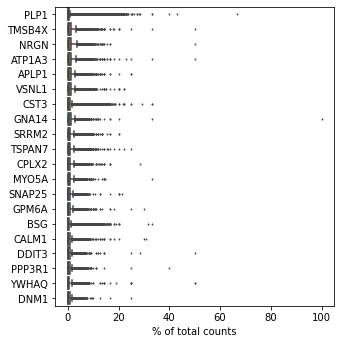

In [76]:
# Plot top 20 most expressed genes (before qc)
sc.pl.highest_expr_genes(adata, n_top=20)

In [77]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

# Calculate max count for each gene
adata.var['max_counts'] = adata.X.max(axis=0)

In [78]:
# Total counts describe statistics
adata.obs['total_counts'].describe()

count    76847.000000
mean       195.050003
std        129.668594
min          0.000000
25%        101.000000
50%        169.000000
75%        259.000000
max       1566.000000
Name: total_counts, dtype: float64

In [79]:
adata.obs['log1p_total_counts'].describe()

count    76847.000000
mean         5.044547
std          0.752100
min          0.000000
25%          4.624973
50%          5.135798
75%          5.560682
max          7.356918
Name: log1p_total_counts, dtype: float64

In [80]:
from scipy import stats
n = 3
mad = stats.median_absolute_deviation(adata.obs['log1p_total_counts'], scale=1)
lower_bd = adata.obs['log1p_total_counts'].median() - n*mad
upper_bd = adata.obs['log1p_total_counts'].median() + n*mad

print(lower_bd)
print(upper_bd)
print(np.expm1(lower_bd))
print(np.expm1(upper_bd))

3.747927665710449
6.523669242858887
41.43305534563548
680.0728277929968


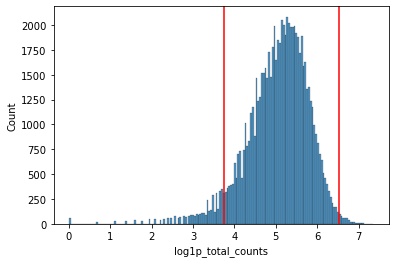

In [81]:
sns.histplot(adata.obs['log1p_total_counts'])
plt.axvline(lower_bd, c='r')
plt.axvline(upper_bd, c='r')
plt.savefig(os.path.join(fig_path, 'reads_filtering_threshold.pdf'))
plt.show()

In [82]:
# Total counts describe statistics
adata.var['total_counts'].describe()

count      2766.000000
mean       5419.019043
std       10536.302734
min         150.000000
25%        1214.000000
50%        2408.500000
75%        5039.000000
max      153164.000000
Name: total_counts, dtype: float64

In [83]:
# max counts describe statistics
adata.var['max_counts'].describe()

count    2766.000000
mean        4.422994
std         4.450788
min         2.000000
25%         3.000000
50%         3.000000
75%         5.000000
max       133.000000
Name: max_counts, dtype: float64

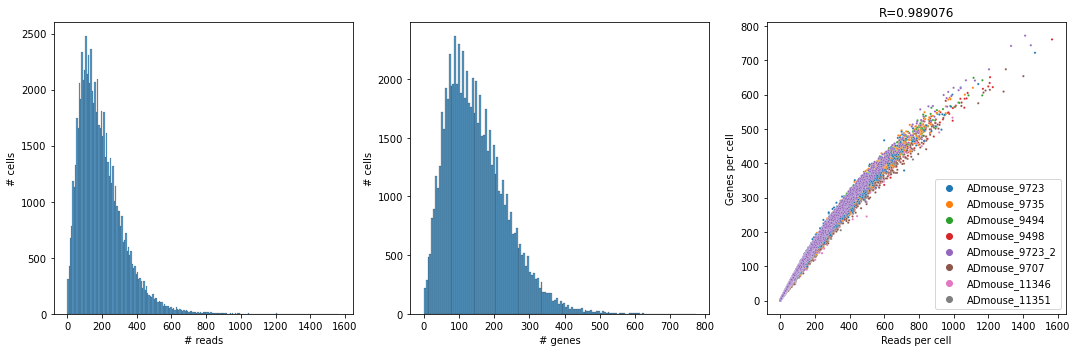

In [84]:
# Per-cell Stats Plot

su.plot_stats_per_cell(adata, color='sample', save=os.path.join(fig_path, 'cell_stats_before_filtering.pdf'))

In [85]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     60.0
0.25    101.0
0.50    169.0
0.75    259.0
0.90    361.0
Name: total_counts, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


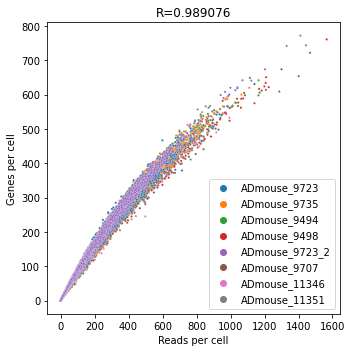

In [91]:
reads_per_cell = adata.obs['total_counts']
genes_per_cell = adata.obs['n_genes_by_counts']

fig, ax = plt.subplots(figsize=(5,5))
plt.title(
    'R=%f' % np.corrcoef(reads_per_cell.T, genes_per_cell)[0, 1])  # Pearson product-moment correlation coefficients
sns.scatterplot(data=adata.obs, x='total_counts', y='n_genes_by_counts', hue='sample', s=5)
plt.xlabel("Reads per cell")
plt.ylabel("Genes per cell")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'test.eps'))
plt.show()

### Filtration

In [63]:
# Filter gene by max counts 
adata.var['detected'] = adata.var['max_counts'] > 2
adata.var['highly_variable'] = adata.var['max_counts'] > 2
print(adata.var['detected'].sum())

2347


In [64]:
# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

# # Filter gene by max counts 
# adata = adata[:, adata.var['max_counts'] > 2]

sc.pp.filter_cells(adata, min_counts=np.expm1(lower_bd))
sc.pp.filter_cells(adata, max_counts=np.expm1(upper_bd))

adata.layers['raw'] = adata.X
adata.X.shape

(72310, 2766)

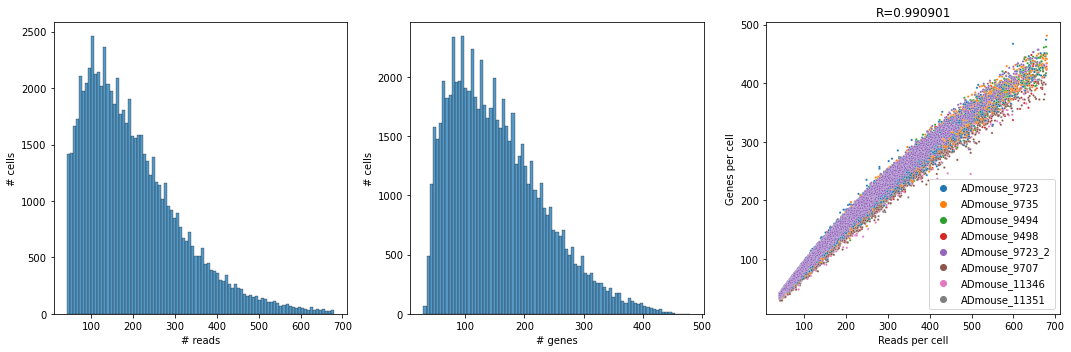

In [66]:
# Per-cell Stats Plot

su.plot_stats_per_cell(adata, color='sample', save=os.path.join(fig_path, 'cell_stats_after_filtering.pdf'))

In [67]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     74.0
0.25    111.0
0.50    175.0
0.75    263.0
0.90    361.0
Name: total_counts, dtype: float64


         Falling back to preprocessing with `sc.pp.pca` and default params.


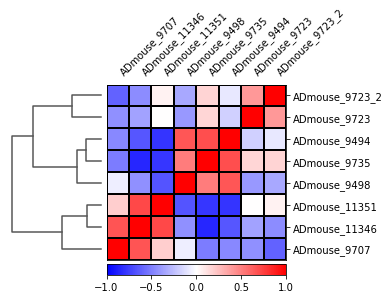

In [68]:
sc.pl.correlation_matrix(adata, 'sample', figsize=(5,3.5))

### Output

In [22]:
# save combined h5ad
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(f"{out_path}/{date}-Hu-AD-stardist-filtered-{n}mad.h5ad")